In [1]:
%matplotlib inline

#### Import Package

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils import data
import numpy as np
import vision
from vision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import time
import os
import copy

plt.ion()   # interactive mode

#### overwrite dataset

In [3]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx, extensions):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images

class My_Dataset(data.Dataset):
    def __init__(self, root, extensions, transform=None, target_transform=None, loader=default_loader):
        classes, class_to_idx = find_classes(root)
        samples = make_dataset(root, class_to_idx, extensions)
        if len(samples) == 0:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(extensions)))

        self.root = root
        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        path_split = path.split('\\')
        name = path_split[len(path_split)-1]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target, name

    def __len__(self):
        return len(self.samples)

#### Load image

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\Zhiyang\\Desktop\\Semantic-segmentation\\classdification\\dataset-catdog'
# print(os.path.join('C:\\Users\\Zhiyang\\Desktop\\Semantic-segmentation\\classdification\\dataset-catdog', 'train'))
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
image_datasets = {x: My_Dataset(os.path.join(data_dir, 'train'), '.jpg', 
                                         data_transforms[x])
                       for x in ['train', 'val']}

dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
                  for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

#### load bounding box xml 

In [5]:
print(next(iter(dataloaders['train'])))

[
( 0 , 0 ,.,.) = 
 -1.1589 -1.2103 -1.1075  ...   0.8104  0.8618  0.9303
 -1.0390 -1.1418 -1.1418  ...   0.7933  0.8276  0.8789
 -0.9534 -1.0904 -1.1589  ...   0.8104  0.7933  0.8276
           ...             ⋱             ...          
 -0.0972  0.2111  0.2796  ...  -0.5253 -0.7308 -0.7822
  0.1254  0.2796  0.2282  ...  -0.4054 -0.6452 -0.7822
  0.3481  0.2967  0.1426  ...  -0.4226 -0.5767 -0.7308

( 0 , 1 ,.,.) = 
 -1.2654 -1.3179 -1.2304  ...   1.0455  1.0980  1.1681
 -1.1078 -1.2129 -1.2479  ...   1.0280  1.0630  1.0980
 -1.0203 -1.1604 -1.2479  ...   1.0455  1.0280  1.0280
           ...             ⋱             ...          
 -0.4951 -0.1800 -0.1099  ...  -0.6001 -0.8277 -0.8803
 -0.2675 -0.1099 -0.1800  ...  -0.5126 -0.7402 -0.8803
 -0.0399 -0.0924 -0.2675  ...  -0.5301 -0.7052 -0.8452

( 0 , 2 ,.,.) = 
 -1.3164 -1.3687 -1.2816  ...   1.3328  1.3851  1.4548
 -1.1596 -1.2467 -1.2641  ...   1.3154  1.3502  1.3851
 -1.0376 -1.1770 -1.2641  ...   1.3328  1.3154  1.3328
          

#### Show Image Sample

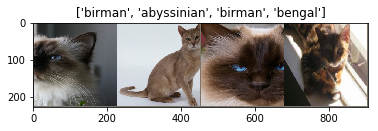

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, img_name = next(iter(dataloaders['train']))

# Make a grid from batch
out = vision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



#### calcultae IoU

In [ ]:
def overlapped_area(a, b):  # returns None if rectangles don't intersect
    dx = min(a[1], b[1]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[2], b[2])
    if (dx>=0) and (dy>=0):
        return dx*dy
    
def IntersectionOfUnion(a, b):
    size_a = (a[1]-a[0])*(a[3]-a[2])
    size_b = (b[1]-b[0])*(b[3]-b[2])
    intersection = overlapped_area(a, b)
    union = size_a + size_b - overlapped_area(a, b)
    return intersection / union

IntersectionOfUnion([0,1,2,3], [0,2,1,3])

#### Model training function

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
#                 model_bbox.train(True)
            else:
                model.train(False)  # Set model to evaluate mode
#                 model_bbox.train(False)
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                
                # get the inputs
                inputs, labels, img_name = data
                # get bounding box ground truth
                xml_name = []
                xml_gt = []
                for name in img_name:
                    xml_name.append(name.split('.')[0] + '.xml')
                for file in xml_name:
                    lower_prefix = file.split('_')[0].lower()
                    file_path = os.path.join('C:\\Users\\Zhiyang\\Desktop\\Semantic-segmentation\\classdification\\dataset-catdog\\annotation',
                                       phase, lower_prefix, file) 
                    tree = ET.parse(file_path)
                    root = tree.getroot()
                    temp = []
                    for para in root[5][4].itertext():
                        temp.append(para)
                    xml_gt.append(temp)                 
                xml_gt_array = np.asarray(xml_gt, dtype=np.float32)
                bbox_gt = torch.from_numpy(xml_gt_array)

                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    bbox_gt = Variable(bbox_gt.cuda())
                else:
                    inputs, labels, bbox_gt = Variable(inputs), Variable(labels), Variable(bbox_gt)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
#                 outputs, outputs_bbox = model(inputs)
                outputs = model(inputs)

                print("1: ", outputs)
#                 print("2:", outputs_bbox)            
#                 print("3:", outputs_test)            

                
#                 outputs_bbox = model_bbox(inputs)


                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
#                 loss_bbox = criterion(outputs_bbox, bbox_gt)
                
                

                
#                 print("loss of bbox", loss_bbox)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualizing the model predictions 

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#### Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft.fc_bbox = nn.Linear(num_ftrs, 4)


if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
1:  Variable containing:
-0.7489  0.0539  0.4701
-0.5681  0.3259 -0.0609
 0.0426 -0.3408  0.4617
-0.0068  0.3385  0.2792
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-0.0367  0.3053  0.3906
 0.2285 -0.1444 -0.1085
 0.0639 -0.2761  0.1486
-0.6750  0.4058  0.0347
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
 0.4937 -0.1999 -0.3736
-0.1858  0.2729 -0.0579
 0.5503  0.2219  0.7604
-0.1094 -0.2621 -0.8570
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
 0.3060  0.0771  0.1197
 1.2873  0.4037 -0.2455
-0.0116 -0.8922 -0.7523
 0.2649  0.2051 -0.4130
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
 0.8737 -0.1226 -0.0853
 1.2067 -0.5199 -0.0776
 0.1000 -0.0585 -0.9942
 0.2473  0.4232 -0.7852
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
 0.3318 -0.2612 -0.0364
 1.2464 -0.1827 -0.2199
 0.4875  0.1220 -1.0396
 0.4906  0.5730 -1.1417
[torch.cuda.FloatTenso


1:  Variable containing:
 1.5976  0.6916 -1.6291
-2.7265 -0.9461  3.6744
-1.8927  0.6044  1.4838
-0.5585  1.9666 -2.0296
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-2.1137 -2.2803  4.3915
-2.6206  4.0509 -1.8059
 0.2404  1.7709 -1.4621
 0.4413 -0.9460  0.6445
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-2.0583  1.0893 -0.0091
-0.0320 -0.7092  0.5356
-2.4890  1.1812  2.1143
 0.7463  0.3094 -0.2031
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-0.1277  2.9048 -2.4517
 0.4891  1.8463 -2.9914
-2.1517 -0.6911  2.7928
-1.7011 -2.3460  4.6319
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-2.2978 -1.8594  4.2537
-0.9195 -1.4131  2.5185
 1.1077  0.7546 -1.8466
 0.2441  2.9379 -3.2179
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

1:  Variable containing:
-2.2606 -3.0986  6.0637
 0.6887  1.0548 -1.4981
 1.3840 -0.0174 -1.3609
 0.3532  1.2461 -2.2867
[torch.cuda.FloatTensor of size 4x3 (GPU 0)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Zhiyang\\Desktop\\Semantic-segmentation\\classdification\\dataset-catdog\\annotation\\val\\bengal\\Bengal_105.xml'

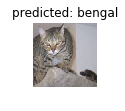

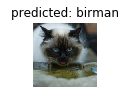

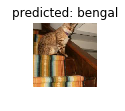

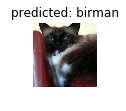

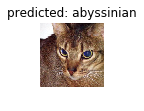

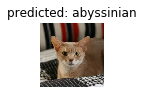

In [20]:
visualize_model(model_ft)

#### Calculate IoU

In [44]:
def overlapped_area(a, b):  # returns None if rectangles don't intersect
    dx = min(a[1], b[1]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[2], b[2])
    if (dx>=0) and (dy>=0):
        return dx*dy
    
def IntersectionOfUnion(a, b):
    size_a = (a[1]-a[0])*(a[3]-a[2])
    size_b = (b[1]-b[0])*(b[3]-b[2])
    intersection = overlapped_area(a, b)
    union = size_a + size_b - overlapped_area(a, b)
    return intersection / union

IntersectionOfUnion([0,1,2,3], [0,2,1,3])

#### Parse XML to extract boundbox

333
72
425
158
72
105
288
291
151
71
335
267
54
36
319
235
23
27
325
320
241
68
362
196
237
101
373
227
861
156
1302
563
94
76
275
271
50
14
336
304
81
7
246
146
43
57
94
105
25
8
175
162
298
94
423
213
112
17
433
340
300
95
403
196
222
64
351
185
238
52
391
175
71
43
249
190
72
102
217
222
1
34
257
303
39
51
156
179
94
83
211
190
63
85
166
180
68
13
195
138
195
10
278
100
153
81
333
221
88
94
207
195
215
23
393
176
88
87
204
182
96
246
179
328
46
22
166
168
114
94
252
224
145
25
218
96
93
85
255
230
17
25
206
180
200
106
278
179
63
50
219
227
74
1
389
309
20
58
257
278
105
38
227
157
593
108
1017
549
250
60
378
186
106
60
227
168
164
71
252
163
231
87
323
154
35
106
326
343
168
65
345
239
160
20
411
260
91
15
238
164
230
112
403
271
39
56
242
266
303
78
460
219
155
39
347
251
16
16
431
357
160
17
491
307
163
61
212
109
154
38
336
238
346
77
409
162
139
42
360
237
58
44
213
215
283
26
410
167
87
1
295
204
154
1
347
231
26
12
95
68
375
53
458
134
274
100
380
207
224
1
470
200
189
166
26

In [73]:
os.chdir('C:\\Users\\Zhiyang\\Desktop\\Semantic-segmentation\\classdification')